In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np

In [ ]:
def unify_96_to_98(data):

    if data.shape[1] == 96:
        # 각 행의 평균값 계산
        row_mean = np.mean(data, axis=1, keepdims=True)  # (n, 1)
        # 평균값을 2개로 확장
        two_means = np.hstack([row_mean, row_mean])       # (n, 2)
        # 기존 데이터 + 평균값 2개
        data_98 = np.hstack([data, two_means])           # (n, 98)
        return data_98
    elif data.shape[1] == 98:
        # 이미 98이면 그대로 반환
        return data
    else:
        raise ValueError(f"데이터 shape {data.shape}가 예상치와 다릅니다 (96 또는 98만 허용).")

In [ ]:
!pip install tqdm

저장된 파일 데이터를 이용하는 경우

In [ ]:
# %% [markdown]
## 저장된 파일 데이터를 이용할때

# %% [code]
import numpy as np

normal_arr = np.load("/content/drive/MyDrive/list/train_normal_arr.npy")
caution_arr = np.load("/content/drive/MyDrive/list/train_caution_arr.npy")
defect_arr = np.load("/content/drive/MyDrive/list/train_defect_arr.npy")


In [ ]:
import numpy as np

# 슬라이딩 윈도우 생성 함수
def create_sliding_windows(arr, window_size=100, step=30):
    n_rows = arr.shape[0]
    windows = []
    for i in range(0, n_rows - window_size + 1, step):
        windows.append(arr[i:i+window_size])
    return np.array(windows)

# 각 배열에 대해 슬라이딩 윈도우 적용
normal_windows = create_sliding_windows(normal_arr, window_size=100, step=30)   # shape: (192, 100, 98)
caution_windows = create_sliding_windows(caution_arr, window_size=100, step=30)   # shape: (197, 100, 98)
defect_windows = create_sliding_windows(defect_arr, window_size=100, step=30)     # shape: (198, 100, 98)

# 각 데이터별 라벨 생성
normal_labels = np.zeros(len(normal_windows))         # 정상: 0, 길이: 192
caution_labels = np.ones(len(caution_windows))          # 주의: 1, 길이: 197
defect_labels = np.full(len(defect_windows), 2)           # 결함: 2, 길이: 198

# 모든 윈도우 데이터를 concat (axis=0)하여 하나의 X 배열 생성
X_train = np.concatenate([normal_windows, caution_windows, defect_windows], axis=0)
# 모든 라벨을 concat하여 하나의 y 배열 생성
y_train = np.concatenate([normal_labels, caution_labels, defect_labels], axis=0)

print("최종 X shape:", X_train.shape)
print("최종 y shape:", y_train.shape)


최종 X shape: (64642, 100, 98)
최종 y shape: (64642,)


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# X의 shape: (전체 윈도우 수, 100, 98)
n_samples, win_size, num_features = X_train.shape
# 2차원 입력으로 변환: (전체 윈도우 수, 100*98)
X_train = X_train.reshape(n_samples, win_size * num_features)

In [ ]:
print(X_train.shape)

(64642, 9800)


CNN 이미지의 사이즈를 다시 맞춰 주기

In [ ]:
import math

pixel_count = 9800  # 현재 한 샘플의 픽셀 수
for c in [1, 3]:  # 흑백(1채널) 또는 컬러(3채널) 가정
    h_w = pixel_count / c
    sqrt_hw = math.sqrt(h_w)
    if sqrt_hw.is_integer():
        print(f"Possible shape: ({int(sqrt_hw)}, {int(sqrt_hw)}, {c})")


In [ ]:
X_train = X_train.reshape(-1, 100, 98, 1)  # 흑백 이미지라면
X_train = np.repeat(X_train, 3, axis=-1)  # 1채널 → 3채널 변환 (필요한 경우)


LSTM 기반 CNN코드 작성 진행

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive

# Google Drive 연결
drive.mount('/content/drive', force_remount=True)

# 데이터 로드
X_train_path = '/content/drive/MyDrive/X_train.npy'
Y_train_path = '/content/drive/MyDrive/Y_train.npy'

X_train = np.load(X_train_path)
y_train = np.load(Y_train_path)

# 데이터 크기 확인
print("Original X_train shape:", X_train.shape)

# 데이터 차원 변경 (CNN 입력 형태 맞추기)
num_samples = X_train.shape[0]  # 샘플 개수
feature_size = X_train.shape[1]  # 각 샘플의 feature 개수

# CNN 입력에 맞는 이미지 크기 자동 탐색
possible_shapes = [(100, 98, 1), (70, 70, 2)]  # 예상 가능한 크기
image_shape = None

for shape in possible_shapes:
    h, w, c = shape
    if h * w * c == feature_size:
        image_shape = (h, w, c)
        break

if image_shape is None:
    raise ValueError(f"Cannot reshape data with feature size {feature_size} into valid image format. Check the original dataset.")

img_width, img_height, channels = image_shape
X_train = X_train.reshape(num_samples, img_width, img_height, channels)
print(f"Reshaped X_train to: {X_train.shape}")

# 1채널(흑백) → 3채널(RGB) 변환 (필요 시)
if channels == 1:
    X_train = np.repeat(X_train, 3, axis=-1)
    print(f"Converted grayscale images to RGB, new shape: {X_train.shape}")

# 하이퍼파라미터 설정
batch_size = 32
epochs = 50

# CNN 모델 구성
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 저장 경로 설정
model_dir = '/content/drive/MyDrive/models'
os.makedirs(model_dir, exist_ok=True)
checkpoint_path = os.path.join(model_dir, 'best_model.h5')

# 콜백 설정
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]

# 모델 학습
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callbacks
)

# 최종 모델 저장
final_model_path = os.path.join(model_dir, 'cnn_final_model.h5')
model.save(final_model_path)
print("✅ 모델 학습 및 저장 완료!")

Mounted at /content/drive
Original X_train shape: (64642, 9800)
Reshaped X_train to: (64642, 100, 98, 1)
Converted grayscale images to RGB, new shape: (64642, 100, 98, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9453 - loss: 0.4197
Epoch 1: val_loss improved from inf to 5.94617, saving model to /content/drive/MyDrive/models/best_model.h5


1617/1617 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9453 - loss: 0.4196 - val_accuracy: 0.6297 - val_loss: 5.9462
Epoch 2/50
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9925 - loss: 0.0317
Epoch 2: val_loss improved from 5.94617 to 5.37545, saving model to /content/drive/MyDrive/models/best_model.h5


1617/1617 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9925 - loss: 0.0317 - val_accuracy: 0.4325 - val_loss: 5.3754
Epoch 3/50
1609/1617 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9828 - loss: 0.0855
Epoch 3: val_loss did not improve from 5.37545
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9828 - loss: 0.0853 - val_accuracy: 0.6185 - val_loss: 5.5807
Epoch 4/50
1615/1617 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9888 - loss: 0.0569
Epoch 4: val_loss did not improve from 5.37545
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9888 - loss: 0.0568 - val_accuracy: 0.6552 - val_loss: 9.1851
Epoch 5/50
1613/1617 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9838 - loss: 0.0723
Epoch 5: val_loss did not improve from 5.37545
1617/1617 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9838 - loss: 0.0723 - val_accuracy: 0.5687 - val_loss: 9.1814
Epoch 6/50
1607/1617 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9914 - loss: 0.0365
Epoch 6: val_loss did not impro

✅ 모델 학습 및 저장 완료!


https://pseudo-lab.github.io/Tutorial-Book/chapters/time-series/Ch5-CNN-LSTM.html 참고

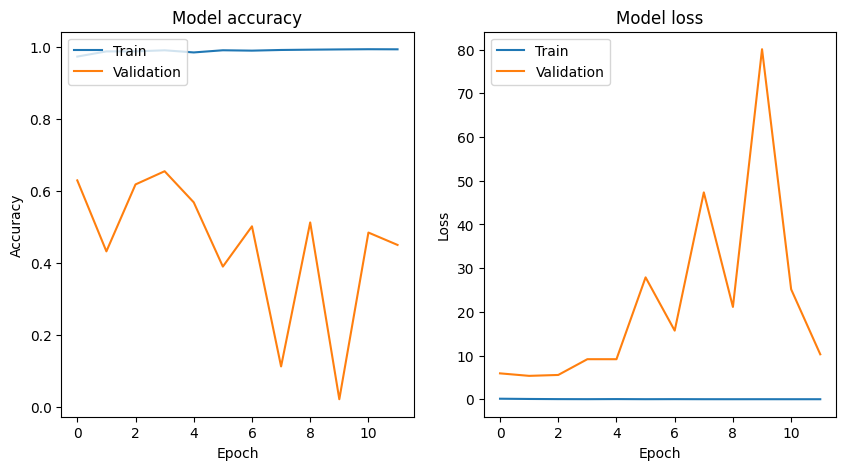

In [ ]:


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


SHAP모델 코드 구현

In [ ]:
import math
pixel_count = 9800  # 한 샘플의 픽셀 수
for c in [1, 3]:  # 흑백(1채널) 또는 컬러(3채널) 가정
    h_w = pixel_count / c
    sqrt_hw = math.sqrt(h_w)
    if sqrt_hw.is_integer():
        print(f"Possible shape: ({int(sqrt_hw)}, {int(sqrt_hw)}, {c})")


In [ ]:
import math

pixel_count = 9800  # 샘플 하나의 픽셀 수
for c in [1, 3]:  # 흑백(1채널) 또는 컬러(3채널) 가정
    h_w = pixel_count / c
    sqrt_hw = math.sqrt(h_w)
    if sqrt_hw.is_integer():
        print(f"Possible shape: ({int(sqrt_hw)}, {int(sqrt_hw)}, {c})")


In [ ]:
sample_img_expanded = sample_img.reshape(1, 100, 98, 1)  # 흑백 채널
sample_img_expanded = np.repeat(sample_img_expanded, 3, axis=-1)  # 1채널 → 3채널 변환


In [ ]:
# 예제 이미지 선택
sample_img = X_train[0]  # 예제 이미지 선택

# CNN 입력에 맞게 변환 (100, 98, 1) -> (100, 98, 3)
sample_img_expanded = sample_img.reshape(1, 100, 98, 1)  # 흑백 이미지로 변환
sample_img_expanded = np.repeat(sample_img_expanded, 3, axis=-1)  # 3채널로 확장

# Grad-CAM 적용
target_layer = 'conv2d_2'  # 시각화할 합성곱 계층 (모델의 구조에 맞게 수정 필요)
heatmap = grad_cam(model, sample_img_expanded, target_layer)


AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
import numpy as np
import tensorflow as tf
import shap
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img

# Grad-CAM 함수 정의
def grad_cam(model, img_array, layer_name):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = tf.reshape(img_array, (-1, 100, 98, 3))  # CNN 입력 크기에 맞게 변환

    _ = model(img_array, training=False)

    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        class_idx = tf.argmax(predictions[0])  # 예측된 클래스
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)  # 그래디언트 계산
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # 특징 맵

    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU 적용
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)  # 정규화
    return heatmap

# SHAP 해석 함수 정의
def shap_explanation(model, img_array):
    explainer = shap.Explainer(model, img_array)
    shap_values = explainer(img_array)
    return shap_values

# 모델 로드
model_path = '/content/drive/MyDrive/models/cnn_final_model.h5'
model = tf.keras.models.load_model(model_path, compile=False)

# 데이터 로드 및 차원 변경
X_train = np.load('/content/drive/MyDrive/X_train.npy')
y_train = np.load('/content/drive/MyDrive/Y_train.npy')

sample_img = X_train[0]
sample_img_expanded = sample_img.reshape(1, 100, 98, 1)
sample_img_expanded = np.repeat(sample_img_expanded, 3, axis=-1)

_ = model(sample_img_expanded, training=False)

# Grad-CAM 적용
target_layer = 'conv2d_2'
heatmap = grad_cam(model, sample_img_expanded, target_layer)

# SHAP 적용
shap_values = shap_explanation(model, sample_img_expanded)

# 시각화
original_img = np.uint8(255 * (sample_img / np.max(sample_img)))
if original_img.shape[-1] == 1:
    original_img = np.squeeze(original_img, axis=-1)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)

result_img = cv2.addWeighted(original_img, 0.5, cv2.applyColorMap(cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0])), cv2.COLORMAP_JET), 0.5, 0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Grad-CAM Heatmap')
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlayed Image')
plt.imshow(result_img)
plt.axis('off')

plt.show()

# SHAP 시각화
shap.image_plot(shap_values)

# Grad-CAM vs SHAP 비교 테이블 출력
import pandas as pd
comparison_table = pd.DataFrame({
    'Method': ['Grad-CAM', 'SHAP'],
    'Interpretability': ['Highlights regions influencing predictions', 'Feature importance at pixel level'],
    'Computation Time': ['Fast', 'Slow'],
    'Robustness': ['Can be misleading in deeper layers', 'More stable across different inputs'],
    'Use Case': ['Visualizing CNN attention', 'Explaining individual predictions']
})

import ace_tools as tools
tools.display_dataframe_to_user(name="Grad-CAM vs SHAP Comparison", dataframe=comparison_table)


AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img

# Grad-CAM 함수 정의
def grad_cam(model, img_array, layer_name):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = tf.reshape(img_array, (-1, 100, 98, 3))  # CNN 입력 크기에 맞게 변환

    # 모델을 먼저 호출하여 입력 크기를 정의
    _ = model(img_array, training=False)

    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        class_idx = tf.argmax(predictions[0])  # 예측된 클래스
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)  # 그래디언트 계산
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # 특징 맵

    # 특징 맵에 가중치 적용
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU 적용
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)  # 정규화
    return heatmap

# Grad-CAM 결과를 원본 이미지 위에 시각화하는 함수
def overlay_heatmap(img, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return overlayed_img

# 모델 로드
model_path = '/content/drive/MyDrive/models/cnn_final_model.h5'
model = tf.keras.models.load_model(model_path, compile=False)

# 데이터 로드 및 차원 변경
X_train = np.load('/content/drive/MyDrive/X_train.npy')
y_train = np.load('/content/drive/MyDrive/Y_train.npy')

# 예제 이미지 선택
sample_img = X_train[0]  # 예제 이미지 선택
sample_img_expanded = sample_img.reshape(1, 100, 98, 1)  # 흑백 이미지로 변환
sample_img_expanded = np.repeat(sample_img_expanded, 3, axis=-1)  # 3채널로 확장

# 모델을 먼저 호출하여 입력 크기 설정
_ = model(sample_img_expanded, training=False)

# Grad-CAM 적용
target_layer = 'conv2d_2'  # 시각화할 합성곱 계층 (모델의 구조에 맞게 수정 필요)
heatmap = grad_cam(model, sample_img_expanded, target_layer)

# 원본 이미지 시각화
original_img = np.uint8(255 * (sample_img / np.max(sample_img)))
if original_img.shape[-1] == 1:
    original_img = np.squeeze(original_img, axis=-1)  # 흑백이면 2D로 변환
    original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)

# Heatmap과 원본 이미지 합성
result_img = overlay_heatmap(original_img, heatmap)

# 결과 출력
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Grad-CAM Heatmap')
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlayed Image')
plt.imshow(result_img)
plt.axis('off')

plt.show()

AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
sample_img = X_train[0]  # 예제 이미지 선택
sample_img_expanded = np.expand_dims(sample_img, axis=-1)  # (100, 98, 1)
sample_img_expanded = np.repeat(sample_img_expanded, 3, axis=-1)  # (100, 98, 3)
sample_img_expanded = np.expand_dims(sample_img_expanded, axis=0)  # (1, 100, 98, 3)


In [ ]:
print("X_train shape:", X_train.shape)


X_train shape: (64642, 9800)


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img

# Grad-CAM 함수 정의
def grad_cam(model, img_array, layer_name):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = tf.reshape(img_array, (-1, 100, 98, 3))  # CNN 입력 크기에 맞게 변환

    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        class_idx = tf.argmax(predictions[0])  # 예측된 클래스
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)  # 그래디언트 계산
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]  # 특징 맵

    # 특징 맵에 가중치 적용
    for i in range(conv_outputs.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU 적용
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)  # 정규화
    return heatmap

# Grad-CAM 결과를 원본 이미지 위에 시각화하는 함수
def overlay_heatmap(img, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return overlayed_img

# 모델 로드
model_path = '/content/drive/MyDrive/models/cnn_final_model.h5'
model = tf.keras.models.load_model(model_path, compile=False)

# 데이터 로드 및 차원 변경
X_train = np.load('/content/drive/MyDrive/X_train.npy')
y_train = np.load('/content/drive/MyDrive/Y_train.npy')

# 예제 이미지 선택
sample_img = X_train[0]  # 예제 이미지 선택
sample_img_expanded = np.expand_dims(sample_img, axis=0)  # 배치 차원 추가
sample_img_expanded = np.reshape(sample_img_expanded, (-1, 100, 98, 3))  # CNN 입력 크기에 맞게 변환

# Grad-CAM 적용
target_layer = 'conv2d_2'  # 시각화할 합성곱 계층 (모델의 구조에 맞게 수정 필요)
heatmap = grad_cam(model, sample_img_expanded, target_layer)

# 원본 이미지 시각화
original_img = np.uint8(255 * (sample_img / np.max(sample_img)))
if original_img.shape[-1] == 1:
    original_img = np.squeeze(original_img, axis=-1)  # 흑백이면 2D로 변환
    original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)

# Heatmap과 원본 이미지 합성
result_img = overlay_heatmap(original_img, heatmap)

# 결과 출력
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Grad-CAM Heatmap')
plt.imshow(heatmap, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlayed Image')
plt.imshow(result_img)
plt.axis('off')

plt.show()


ValueError: cannot reshape array of size 9800 into shape (100,98,3)

In [ ]:
!pip install shap

import shap
import numpy as np

# Load your trained model (replace with your actual model loading)
# Assuming your model is saved as 'cnn_fault_model.h5' in the models directory
model_path = os.path.join('models', '/content/drive/MyDrive/models/cnn_final_model.h5')
model = tf.keras.models.load_model(model_path)


# Load your training data (replace with your actual data loading)
X_train = np.load("/content/drive/MyDrive/X_train.npy")
y_train = np.load("/content/drive/MyDrive/Y_train.npy")

# Choose a subset of your data for SHAP values calculation (for speed)
# Adjust the number of background samples as needed.  Too few can lead to poor explanations
background_data = X_train[:100] # Example: Using first 100 samples as background
explainer = shap.KernelExplainer(model.predict, background_data)

# Select a few instances for explanation (adjust the number of instances)
num_instances_to_explain = 10  # Example: Explain 10 instances
X_test = X_train[100:100 + num_instances_to_explain] # Example: Using samples 100-110
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# You can also visualize individual predictions:
# for i in range(num_instances_to_explain):
#  shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_test[i])
